In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import os
import copy
import time
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
data_dir = 'dataset/food11'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

BATCH_SIZE = 32
NUM_CLASSES = 11

In [ ]:
# Трансформация и создание даталоадера для модели b0

IMG_SIZE_B0 = 224

data_transforms_b0 = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE_B0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(IMG_SIZE_B0), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets_b0 = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_b0[x])
    for x in ['train', 'val']
}

dataloaders_b0 = {
    x: DataLoader(image_datasets_b0[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets_b0[x]) for x in ['train', 'val']}
class_names = image_datasets_b0['train'].classes

In [ ]:
# Загрузка модели b0, заморозка слоев, изменение количества выходных классов, оптимизатор

model_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

for param in model_b0.parameters():
    param.requires_grad = False

num_features = model_b0.classifier[1].in_features
model_b0.classifier[1] = nn.Linear(num_features, NUM_CLASSES)

model_b0 = model_b0.to(device)

loss = nn.CrossEntropyLoss()

optimizer_b0 = optim.Adam(model_b0.classifier.parameters(), lr=0.001)

In [ ]:
def train_model(
        model, model_name, dataloaders,
        crit, optimizer, num_epochs=10
    ):
    """
    Обучает модель нейронной сети и выполняет валидацию по эпохам.
    Сохраняет веса модели, показывающей лучшую точность на валидационном наборе.

    Args:
        model (torch.nn.Module): Обучаемая модель.
        model_name (str): Имя модели, используемое для сохранения файла весов.
        dataloaders (dict): Словарь, содержащий DataLoader'ы для 'train' и 'val' фаз.
                            Пример: {'train': train_loader, 'val': val_loader}.
        crit (torch.nn.Module): Функция потерь (критерий).
        optimizer (torch.optim.Optimizer): Оптимизатор, используемый для обновления весов.
        num_epochs (int, optional): Общее количество эпох для обучения. По умолчанию 10.

    Returns:
        torch.nn.Module: Обученная модель с весами,
                         соответствующими лучшей точности на валидации.
    """
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                description = f'Train epoch {epoch+1}/{num_epochs}'
            else:
                model.eval()
                description = f'Val epoch {epoch+1}/{num_epochs}'
            
            total_loss = 0.0
            corrects = 0.0

            train_tqdm = tqdm(
                dataloaders[phase],
                desc=description,
                leave=True
            )
            for batch_idx, (images, labels) in enumerate(train_tqdm):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(images)
                    _, preds = torch.max(out, 1)
                    loss = crit(out, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                total_loss += loss.item() * images.size(0)
                corrects += torch.sum(preds == labels.data) 

                current_loss = total_loss / (batch_idx + 1) / dataloaders[phase].batch_size
                current_acc = corrects.double() / (batch_idx + 1) / dataloaders[phase].batch_size

                train_tqdm.set_postfix(
                    Loss=f'{current_loss:.4f}', 
                    Acc=f'{current_acc:.4f}'
                )
            epoch_acc = corrects / (batch_idx + 1) / dataloaders[phase].batch_size

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_'+ model_name + '.pth')
    
    print()
    time_elapsed = time.time() - since
    print(f'Обучение завершено за {time_elapsed // 60:.0f}м {time_elapsed % 60:.0f}с')
    print(f'Лучшая точность на валидации: {best_acc:.4f}')

    model.load_state_dict(best_model_weights)
    return model

In [ ]:
# обучение модели b0

model_ft_b0 = train_model(model_b0, 'model_b0',dataloaders_b0, loss, optimizer_b0, num_epochs=5)

Test epoch 5/5: 100%|██████████| 35/35 [00:05<00:00,  6.91it/s, Acc=0.7839, Loss=0.6519]


Обучение завершено за 2м 26с
Лучшая точность на валидации: 0.7839


In [ ]:
def get_confusion_matrix(model, dataloader, device):
    """
    Вычисляет матрицу ошибок (Confusion Matrix) для модели классификации.

    Функция переводит модель в режим оценки (model.eval()) и отключает 
    расчет градиентов для ускорения и экономии памяти.
    
    Args:
        model (torch.nn.Module): Обученная модель PyTorch для оценки.
        dataloader (torch.utils.data.DataLoader): Загрузчик данных, содержащий 
                                                  изображения и истинные метки.
        device (torch.device): Устройство (например, 'cpu' или 'cuda'), 
                               на котором будут выполняться вычисления.

    Returns:
        np.ndarray: Матрица ошибок (confusion matrix) в виде массива NumPy.
                    Строки соответствуют истинным меткам, столбцы — предсказанным.
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            out = model(images)
            _, preds = torch.max(out, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(np.array(all_labels), np.array(all_preds))
    return cm 

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Визуализирует матрицу ошибок (Confusion Matrix) в виде тепловой карты.

    Использует библиотеки Matplotlib и Seaborn для создания понятной 
    визуализации с подписями осей, соответствующими именам классов.

    Args:
        cm (np.ndarray): Матрица ошибок (confusion matrix), 
                         полученная, например, с помощью
                         sklearn.metrics.confusion_matrix.
        class_names (list[str]): Список строковых имен классов. 
                                 Порядок имен должен соответствовать
                                 порядку в матрице CM.

    Returns:
        None: Функция отображает график с помощью plt.show() и
              ничего не возвращает.
    """
    figure, axis = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axis)

    tick_marks = np.arange(len(class_names))

    axis.set_yticks(tick_marks + 0.5)
    axis.set_yticklabels(class_names, rotation=0)

    axis.set_xticks(tick_marks + 0.5)
    axis.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.title('Матрица Ошибок (Confusion Matrix)')
    plt.ylabel('Истинный класс (True Class)')
    plt.xlabel('Предсказанный класс (Predicted Class)')

    plt.tight_layout()
    plt.show()

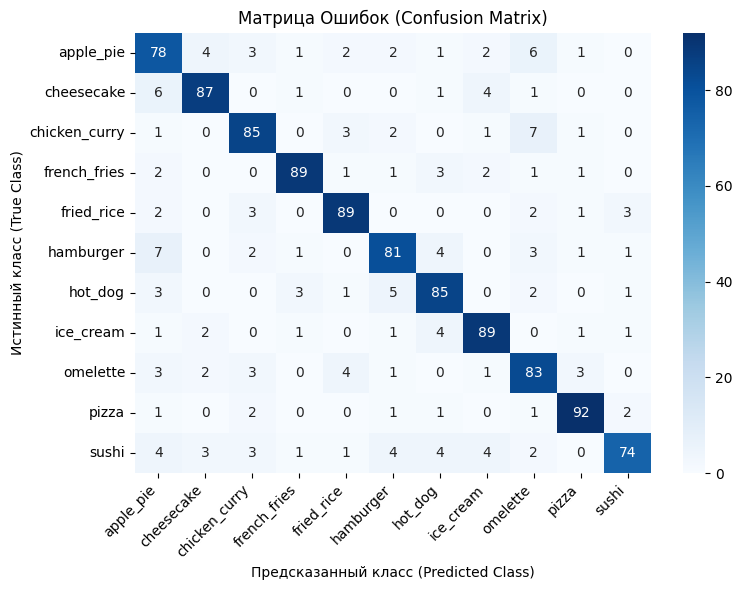

In [ ]:
state_dict_to_load = torch.load('best_model_food11_b0_FINETUNED.pth')
model_b0.load_state_dict(state_dict_to_load)

model_b0.eval()

cm_b0 = get_confusion_matrix(model_b0, dataloaders_b0['val'], device)

plot_confusion_matrix(cm_b0, class_names)

In [ ]:
# Разморозка 3x последних слоев модели b0

for param in model_ft_b0.features[-3:].parameters():
    param.requires_grad = True

optimizer_ft_b0 = optim.Adam(model_ft_b0.parameters(), lr=1e-5)

In [ ]:
# fine tuning и сохранение модели b0 

model_fine_tuned_b0 = train_model(
    model_ft_b0,
    loss, 
    optimizer_ft_b0,
    num_epochs=10
)

torch.save(model_fine_tuned_b0.state_dict(), 'best_model_food11_b0_FINETUNED.pth')

Test epoch 10/10: 100%|██████████| 35/35 [00:05<00:00,  6.53it/s, Acc=0.8321, Loss=0.4549]


Обучение завершено за 5м 50с
Лучшая точность на валидации: 0.8321


In [ ]:
# Использование обученной модели b0 для классификации изображения

from PIL import Image
import numpy as np

image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE_B0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = 'src/pizza.jpg'
image = Image.open(image_path).convert('RGB')
image_tensor = image_transform(image)

input_batch = image_tensor.unsqueeze(0)

input_batch = input_batch.to(device)

model_b0.eval()

with torch.no_grad():
    out = model_b0(input_batch)

    probabilities = nn.functional.softmax(out, dim=1)

    top_p, top_class_index = probabilities.topk(1, dim=1)

    predicted_class_name = class_names[top_class_index.item()]
    predicted_probability = top_p.item()

print(f"Предсказанный класс: {predicted_class_name}")
print(f"Вероятность: {predicted_probability:.4f}")

Предсказанный класс: pizza
Вероятность: 0.9460


In [ ]:
# Трансформация и создание даталоадера для модели b1

IMG_SIZE_B1 = 240

data_transforms_b1 = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE_B1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(IMG_SIZE_B1), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets_b1 = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_b1[x])
    for x in ['train', 'val']
}

dataloaders_b1 = {
    x: DataLoader(image_datasets_b1[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

In [ ]:
# Загрузка модели b1, заморозка слоев, изменение количества выходных классов, оптимизатор

model_b1 = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)

for param in model_b1.parameters():
    param.requires_grad = False

num_features = model_b1.classifier[1].in_features

model_b1.classifier[1] = nn.Linear(num_features, NUM_CLASSES)

model_b1 = model_b1.to(device)

loss = nn.CrossEntropyLoss()

optimizer_b1 = optim.Adam(model_b1.classifier.parameters(), lr=0.001)

In [ ]:
# Обучение модели b1

model_ft_b1 = train_model(model_b1, dataloaders_b1,  loss, optimizer_b1, num_epochs=5)

Test epoch 5/5: 100%|██████████| 35/35 [00:05<00:00,  6.32it/s, Acc=0.7839, Loss=0.6609]


Обучение завершено за 2м 51с
Лучшая точность на валидации: 0.7839
